In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Install Dependencies

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━

IMPORT

In [3]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

Inference with pre-trained RT-DETR model

In [4]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


FINE-TUNE RT-DETR Custom dataset

In [5]:

from roboflow import Roboflow
rf = Roboflow(api_key="I4QCITh9AAzxTZDQ47kz")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(12)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-12 in coco:: 100%|██████████| 380/380 [00:00<00:00, 1737.23it/s]


In [6]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 298
Number of validation images: 49
Number of test images: 25


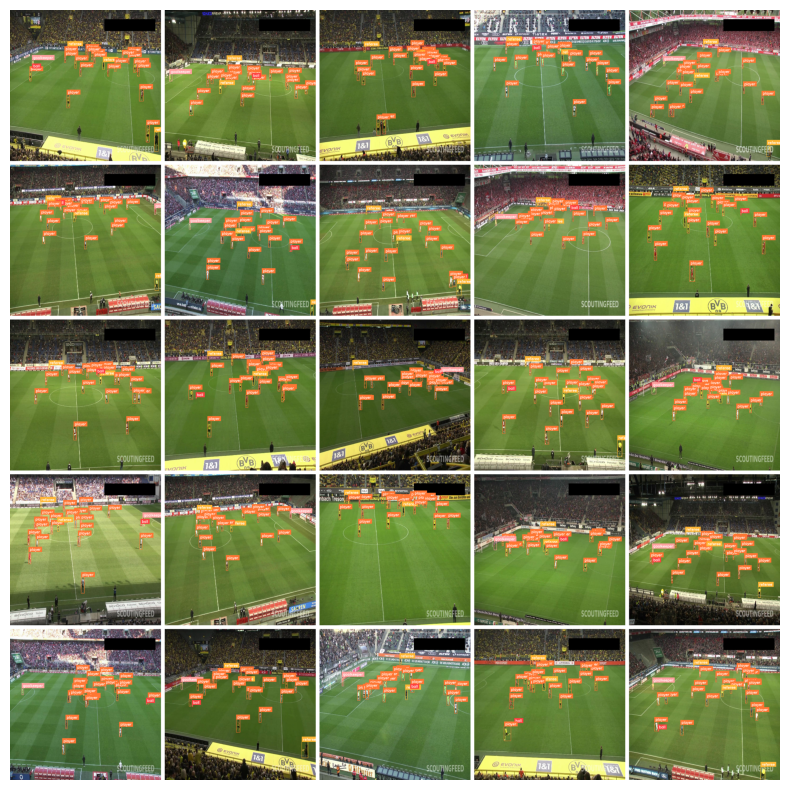

In [7]:
# @title Display dataset sample

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

OUTPUT IMAGE

In [8]:
IMAGE_SIZE = 512

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)


In [9]:
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
        A.ShiftScaleRotate(p=0.2),  # Randomly shift, scale, and rotate
        A.RandomCrop(width=int(IMAGE_SIZE * 0.8), height=int(IMAGE_SIZE * 0.8), p=0.2),  # Random cropping
        A.CoarseDropout(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)


ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.


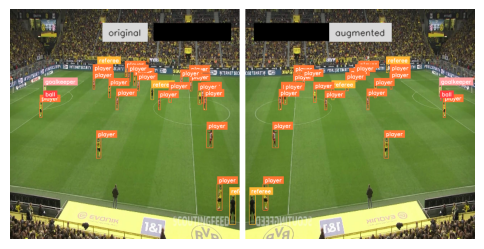

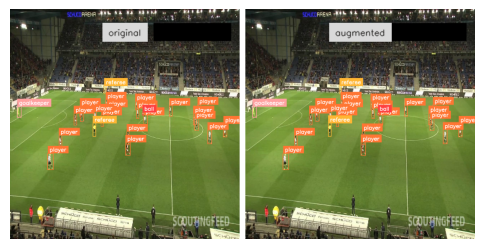

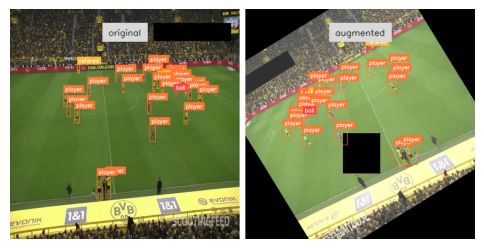

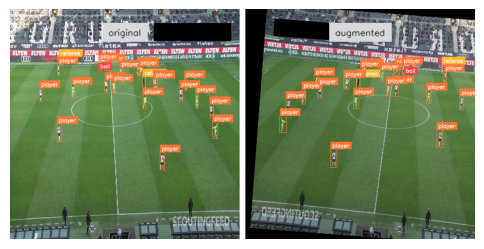

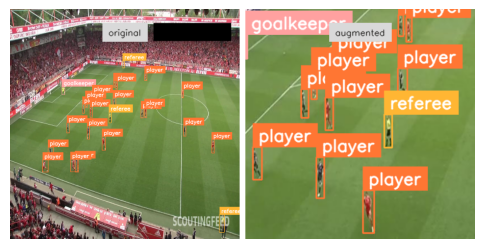

In [10]:
# @title Visualize some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [11]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

In [12]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

pytorch_dataset_train[15]


{'pixel_values': tensor([[[0.3843, 0.3686, 0.3686,  ..., 0.7843, 0.7725, 0.6706],
          [0.3882, 0.3765, 0.3765,  ..., 0.7804, 0.7608, 0.6706],
          [0.3882, 0.3922, 0.3922,  ..., 0.7804, 0.7451, 0.6745],
          ...,
          [0.4902, 0.5294, 0.4784,  ..., 0.3725, 0.3451, 0.2863],
          [0.4588, 0.5098, 0.5020,  ..., 0.2824, 0.2824, 0.2627],
          [0.4588, 0.4941, 0.4784,  ..., 0.2706, 0.2627, 0.2431]],
 
         [[0.3843, 0.3686, 0.3686,  ..., 0.7843, 0.7725, 0.6784],
          [0.3882, 0.3765, 0.3765,  ..., 0.7804, 0.7608, 0.6784],
          [0.3882, 0.3922, 0.3922,  ..., 0.7804, 0.7451, 0.6745],
          ...,
          [0.4902, 0.5294, 0.4784,  ..., 0.3725, 0.3451, 0.2863],
          [0.4588, 0.5098, 0.5020,  ..., 0.2824, 0.2824, 0.2627],
          [0.4588, 0.4941, 0.4784,  ..., 0.2706, 0.2627, 0.2431]],
 
         [[0.3843, 0.3686, 0.3686,  ..., 0.7843, 0.7725, 0.6706],
          [0.3882, 0.3765, 0.3765,  ..., 0.7804, 0.7608, 0.6706],
          [0.3882, 0.392

In [13]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

Compute mAP

In [14]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

class MAPEvaluator:
    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Return fixed image sizes for each target in each batch."""
        image_sizes = []
        for batch in targets:
            # Use the fixed IMAGE_SIZE for all images.
            batch_image_sizes = torch.tensor([[IMAGE_SIZE, IMAGE_SIZE]] * len(batch), dtype=torch.float32)
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, size in zip(target_batch, image_size_batch):
                # Now, size is a 1D tensor with 2 elements (e.g. [480, 480]).
                height = size[0].item()
                width = size[1].item()
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                # Multiply boxes by an array [width, height, width, height]
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(
                logits=torch.tensor(batch_logits),
                pred_boxes=torch.tensor(batch_boxes)
            )
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):
        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per-class metrics with separate metric for each class.
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = self.id2label[class_id.item()] if self.id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)





TRAINNING MODEL
Training involves the following steps:

Load the model with AutoModelForObjectDetection using the same checkpoint as in the preprocessing.

Define your training hyperparameters in TrainingArguments.

Pass the training arguments to Trainer along with the model, dataset, image processor, and data collator.

Call train() to finetune your model.

In [15]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,

)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.

In [16]:
training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=100,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    warmup_ratio=0.1,
    logging_steps=10,
    logging_dir="./logs",
    per_device_train_batch_size=8,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    lr_scheduler_type="cosine",
    fp16=True,
    weight_decay=0.005,
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    processing_class=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
    #callbacks=[CSVLoggerCallback(output_file="training_log.csv")]

)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: quoctuan (ngo-quoc-tuan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


invalid value encountered in divide
There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed

TrainOutput(global_step=3800, training_loss=9.969890833402935, metrics={'train_runtime': 4160.7998, 'train_samples_per_second': 7.162, 'train_steps_per_second': 0.913, 'total_flos': 6.009241044359578e+18, 'train_loss': 9.969890833402935, 'epoch': 100.0})

EVALUATE

In [18]:
targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [19]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.57
map50: 0.85
map75: 0.65


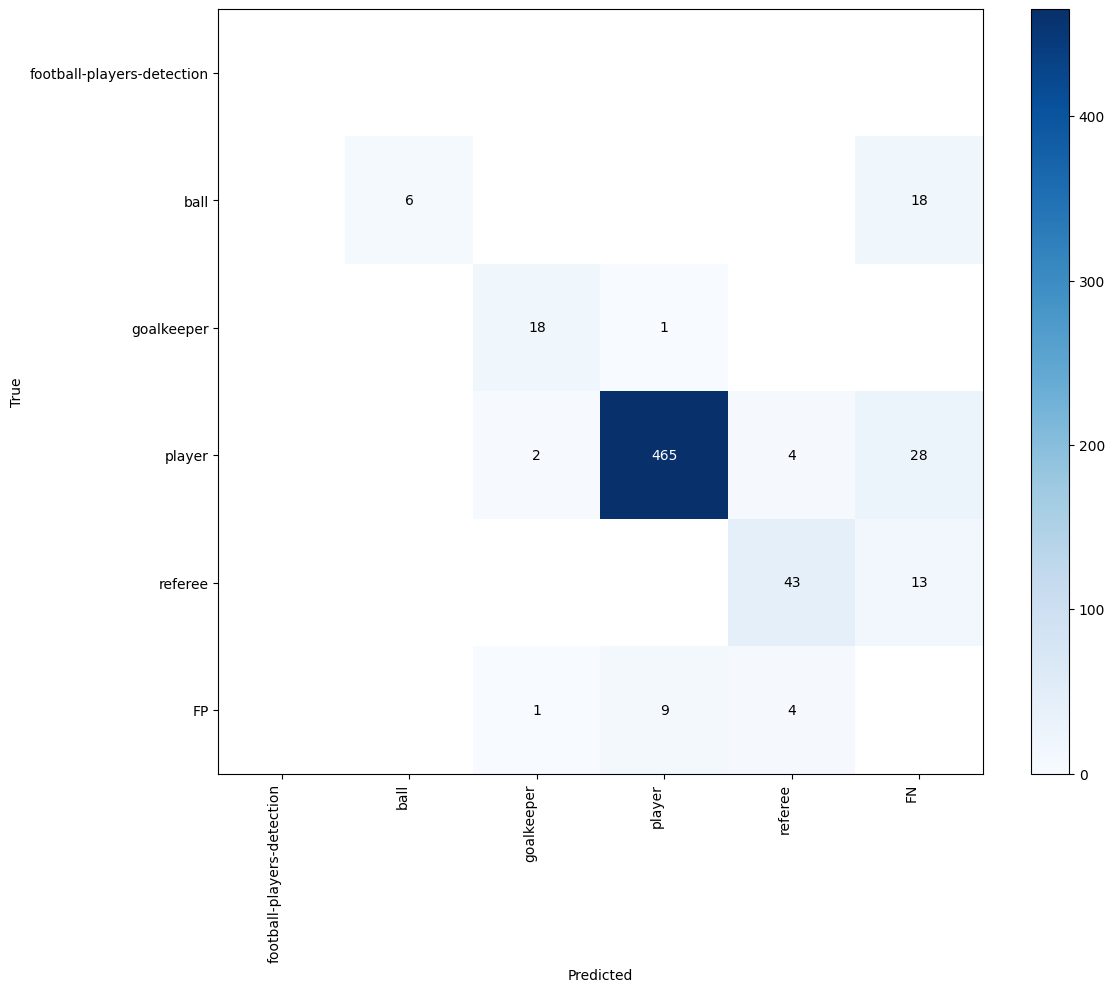

In [20]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

SAVE fine-tuned model on hard drive

In [21]:
model.save_pretrained("/content/rt-detr/")
processor.save_pretrained("/content/rt-detr/")

['/content/rt-detr/preprocessor_config.json']

Inference with fine-tuned RT-DETR model

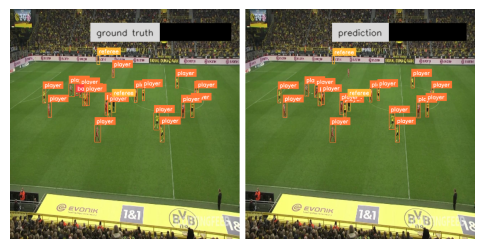

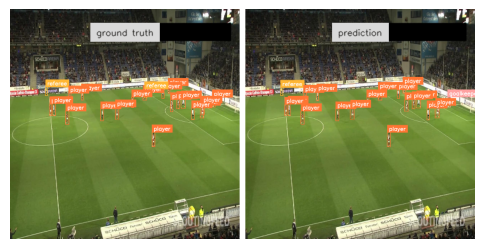

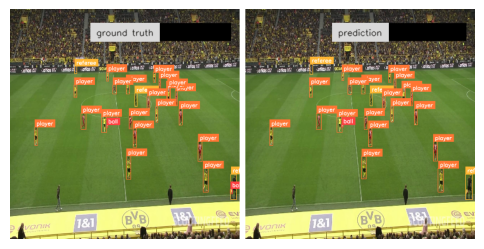

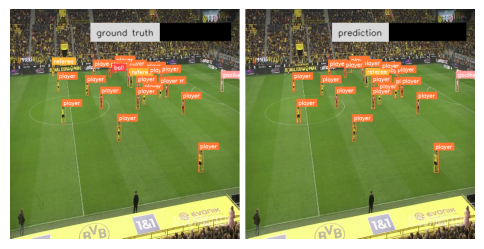

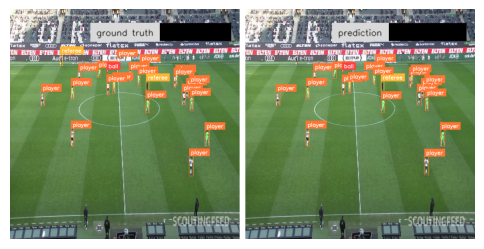

In [22]:
IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Image #12


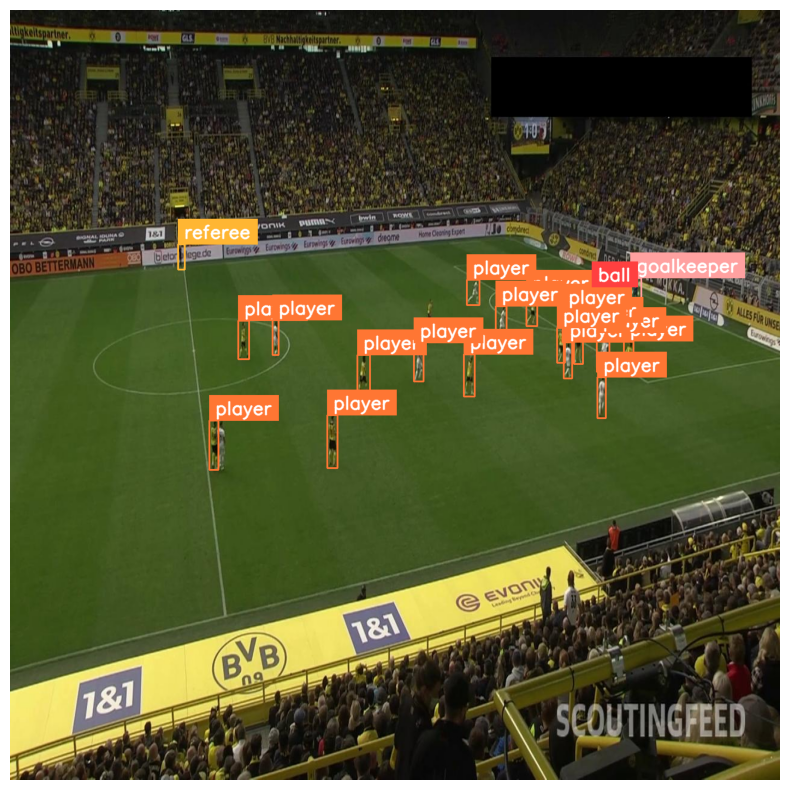

In [23]:
import random
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import supervision as sv

# Assuming `dataset` is the variable holding your Roboflow dataset
annotations_path = f"{dataset.location}/train/_annotations.coco.json"
coco_api = COCO(annotations_path)

# Select a random image ID
image_ids = coco_api.getImgIds()
image_id = random.choice(image_ids)
print(f"Image #{image_id}")

# Load image and annotation data
image_data = coco_api.loadImgs(image_id)[0]
annotations = coco_api.loadAnns(coco_api.getAnnIds(imgIds=image_id))

# Construct the image path using dataset.location
image_path = os.path.join(dataset.location + "/train", image_data['file_name'])
image = Image.open(image_path)

# Prepare the image for the model using your processor
inputs = processor(image, return_tensors="pt").to(DEVICE)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the model output
w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3
)

# Create detections from the results
detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

# Annotate the image with predictions
annotated_image = annotate(image, detections, ds_train.classes)

# Display the annotated image using supervision
sv.plot_image(annotated_image, size=(10, 10))